# Searchlights

In univariate analyses there is a distinction between whole-brain and ROI-based analyses. When done correctly, whole-brain univariate analyses allow you to identify, in an unbiased and data-driven way, regions of the brain that differ between experimental conditions. Compare this to what we have done with multivariate classification: up to this point we have taken ROIs (e.g., FFA, PPA, even the whole brain) and looked at the pattern of activity across voxels. Using these procedures we have been able to determine whether these voxels collectively contain information about different conditions. However, it has been unclear whether a subset of these voxels have been driving classification accuracy, partly because it is tricky to interpret the resulting weights. In other words, we have been unable to say with certainty *where* in the brain there are representations that distinguish between conditions.

A searchlight is a spherical or cubic moving window that allows us to identify and localize such representations. Running a searchlight is computationally intensive because it involves running a separate multivariate analysis for every voxel in the brain. Imagine doing your feature selection, hyper-parameter optimization, and cross-validation 100,000 times or more. Fortunately, brainiak contains a procedure that efficiently carves up brain data into appropriate chunks and distributes them across the computational resources available.
             
For this script we will use the localizer dataset from Kim et al. (2017). 

## Goal of this script
>Learn how to perform a whole-brain searchlight  
>Learn how to replace the kernel used inside the searchlight

In [1]:
# Import libraries
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from utils import load_data, load_labels, label2TR, shift_timing, reshape_data, blockwise_sampling

import time
from nilearn import plotting
from brainiak.searchlight.searchlight import Searchlight
from scipy.sparse import random

# Import machine learning libraries
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.svm import SVC

Prepare a single participant using a similar pipeline to what we have developed previously. The critical change needed here is the shape of the data: In the past we wanted a trial x voxel matrix, but the input to a searchlight is a 3D volume, hence we need to add a step, as below.

**Exercise 1:** Why does the input to a searchlight analysis need to be 3D rather than 2D?

We need to sweep through a *volume* of brain tissue using our searchlight, not a plane. Thus, it must be 3D rather than 2D.

In [2]:
# Preset variables
dir = '/gpfs/milgram/data/cmhn-s18/datasets/vdc/'
num_runs=3
TR=1.5
hrf_lag = 4.5  # In seconds what is the lag between a stimulus onset and the peak bold response
shift_size = int(hrf_lag / TR) # Convert the shift into TRs

sub_id = 1

# Convert the number into a participant folder name
if (sub_id < 10):
    sids = '0' + str(sub_id)
else:
    sids = str(sub_id)   

# Specify the subject name
sub = 'sub-' + sids

# Load subject labels
stim_label_allruns = load_labels(dir, sub)

# Load the fMRI data
epi_mask_data_all, whole_brain_mask = load_data(directory=dir, subject_name=sub, mask_name='', zscore_data=True)

# How many events are there on this run
_, events = stim_label_allruns.shape
events_run = int(events / num_runs)

# This can differ per participant
print(sub, '= TRs: ', epi_mask_data_all.shape[1], '; Voxels: ', epi_mask_data_all.shape[0])
TRs_run = int(epi_mask_data_all.shape[1] / num_runs)

# Convert the timing into TR indexes
stim_label_TR = label2TR(stim_label_allruns, num_runs, TR, TRs_run, events_run)

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

# Perform the reshaping of the data
bold_data, labels = reshape_data(stim_label_TR_shifted, epi_mask_data_all)

# Down sample the data to be blockwise rather than trialwise
bold_data, labels = blockwise_sampling(bold_data, labels)

Loaded  sub-01
Processing Start ...
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
sub-01 = TRs:  930 ; Voxels:  177314
Expected blocks: 45; Resampled blocks: 45


In [3]:
# Reshape the data so that they are a 3D volume stacked in time (4D array)

bold_vol = np.zeros((whole_brain_mask.shape[0], whole_brain_mask.shape[1], whole_brain_mask.shape[2], bold_data.shape[0]))  # Preset the shape of the output
coords = np.where(whole_brain_mask)  # Where are the non zero values
bold_vol[coords[0], coords[1], coords[2], :] = bold_data.T  # Insert the bold data

Now we save the data you created. We want to do this so that it will be easier to read the data into the searchlight function we will use later. However, be aware that saving many copies of your data is wasteful and unnecessary. In fact, it is the nilearn philosophy to save as little data as possible, ideally only saving your raw data and analysis code -- which are sufficient to replicate the analysis -- along with any outputs needed for visualizing the results. To save data with nibabel we need information about the voxel size and orientation of the brain in the data matrix.

In [4]:
# Get the nifti parameters (would have been better to get these when we loaded in the data)
nii = nib.load(dir + sub + "/preprocessed/loc/%s_filtered2_d1_firstExampleFunc_r%d.nii" % (sub, 1))
affine_mat = nii.affine  # What is the orientation of the data
dimsize = nii.header.get_zooms()  # How big is each dimension of the data (first three are voxel size in mm, last is TR duration in s)

output_name = ('%s_input.nii.gz' % (sub))

# Save the volume
bold_nii = nib.Nifti1Image(bold_vol, affine_mat)
hdr = bold_nii.header
hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2], dimsize[3]))
nib.save(bold_nii, output_name)  # Save

# Also save the mask data
output_name = ('%s_mask.nii.gz' % (sub))

mask_nii = nib.Nifti1Image(whole_brain_mask, affine_mat)
hdr = mask_nii.header
hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
nib.save(mask_nii, output_name)  # Save

# Save the label data
output_name = ('%s_labels.npy' % (sub))
np.save(output_name, labels)

## Running a searchlight

Below we go through a toy example of a searchlight and then move onto a real example. Think of a searchlight as a processing step in which you pull out a certain size chunk of your data and then perform a kernel operation (specified by a function you write). You can use any kernel on this chunk of data interchangeably. Critically, the searchlight function **does not** specify the analysis you want to perform, all it does is carve up the data.

As mentioned before, searchlights are computationally intensive and so we need to be aware of what kind of burden they might impose. In the participant you loaded, we want to perform the operation about 177,000 times (once for each of their brain voxels). If we were to run this serially, even if each operation only took 1 s to complete, the analysis would take 50 hours(!), and only for this one participant. With nested cross-validation or other recursive steps, the full analysis could take months or years (and you'd lose a lot of points on your assignment).

Fortunately, the searchlight function in brainiak intelligently parallelizes your data to give you a considerable and scalable speed boost. Parallelization is the idea that when two or more computational tasks can be completed independently (because they don't interact in any way) then it is possible to run these tasks simultaneously on different cores (cores are our unit of serial processing, though there are other parallelizations available within-core, such as threads or even multiple instructions within thread). The nice thing about parallelization is that it is scalable: in general, a job parallelized across 10 cores will run 10 times faster than on one core. For reference, your computer likely has 2, 4, or more cores, so you could speed up processing if you recruited all of these resources (and shut down all other types of background processing). Milgram, the cluster you are running on, has about 1,500 cores, meaning in theory if you could run a job simultaneously across all of these cores then the searchlight we talked about before would be taken down from 50 hours to 2 mins. In practice, there is often some start up cost when calling a function, such as loading the data, which could reduce this benefit a little (maybe to 5 mins).

So remember, the two main things that determine the speed of a searchlight: the kernel algorithm and the amount of parallelization.

Searchlights can be tricky to code properly. When writing the kernel you need to keep in mind that the input data that the function receives is not the size of the original data but is instead the size of the searchlight. Also if you don't scale up your code gently then you might run a searchlight that takes a very long time to finish only to find there was a small error (this happens a lot!). Instead it is better to write a simple function that runs quickly so you can check your code works properly before scaling up.

After you have done a quick check to see that the code works, we recommend having the following checks in place (and then removing them after everything is working):  
>Timestamps to extract the execution time  
>Print the number of voxels that are passed to the searchlight function  
>On the server, you can also check how much memory is being used (sacct -j $JID --format=jobid,maxvmsize).  

Taking our own advice, we are going to write a searchlight script below to perform a very, very simple searchlight. In fact we are only going to run this searchlight on one voxel in the brain so that we can see whether our code is working and how long each searchlight would take. 

The searchlight function needs the following:  

1. **data** = The brain data as a 4D volume.  
2. **mask** = A binary mask specifying the "center" voxels in the brain around which you want to perform searchlight analyses. A searchlight will be drawn around every voxel = 1; hence, it may include voxels outside of your mask, it is up to you to decide whether then to include them.  
3. **bcvar** = An additional variable which can be a list, numpy array, dictionary, etc. you want to use in your searchlight kernel. For instance you might want the condition labels so that you can determine to which condition each 3D volume corresponds. If you don't need to broadcast anything, e.g, when doing RSA, set this to 'None'.  
4. **sl_rad** = The size of the searchlight's radius, excluding the center voxel. This means the total volume size of the searchlight, if using a cube, is defined as: ((2 * sl_rad) + 1) ^ 3.  
5. **max_blk_edge** = When the searchlight function carves the data up into chunks, it doesn't distribute only a single searchlight's worth of data. Instead, it creates a block of data, with the edge length specified by this variable, which determines the number of searchlights to run within a job.  
6. **pool_size** = Maximum number of cores running on a block (typically 1).  

**Exercise 2:** Searchlights don't need to be cubes. What other shape(s) does brainiak support and how do you specify this?

From https://github.com/brainiak/brainiak/blob/master/brainiak/searchlight/searchlight.py, there are two built-in searchlight shape classes: Cube and Diamond. It is also possible for the user to specify a custom shape by building his/her own class. This class gets passed in to the "shape" parameter of the searchlight function, as per https://pythonhosted.org/brainiak/brainiak.searchlight.html.

In [10]:
# Make a mask of only one arbitrary voxel
small_mask = np.zeros(whole_brain_mask.shape)
print(np.sum(whole_brain_mask))
small_mask[80, 54, 9] = 1

177314


In [12]:
# Preset the variables
data = bold_vol
mask = small_mask
bcvar = labels
sl_rad = 1
max_blk_edge = 5
pool_size = 1

# We will get back to these commands once we finish running a simple searchlight. 
#comm = MPI.COMM_WORLD
#rank = comm.rank
#size = comm.size

# Start the clock to time searchlight.
begin_time = time.time()

print("Begin SearchLight")

# Create the searchlight object
sl = Searchlight(sl_rad=sl_rad,max_blk_edge=max_blk_edge)

# Distribute the information to the searchlights (preparing it to run)
sl.distribute([data], mask)

#Data that is needed for all searchlights is sent to all cores via the sl.broadcast function. In this example, we are sending the labels for classification to all searchlights.
sl.broadcast(bcvar)

# Set up the kernel, in this case an SVM
def calc_svm(data, mask, myrad, bcvar):
    
    # Pull out the data
    data4D = data[0]
    labels = bcvar
    
    bolddata_sl = data4D.reshape(mask.shape[0] * mask.shape[1] * mask.shape[2], data[0].shape[3]).T

    # Check if the number of voxels is what you expect.
    print("Input data reshaped: " + str(bolddata_sl.shape))
    print("Input mask:\n" + str(mask) + "\n")
    
    t1 = time.time()
    clf = SVC(kernel='linear', C=1)
    scores = cross_val_score(clf, bolddata_sl, labels, cv=3)
    accuracy = scores.mean()
    t2 = time.time()
    
    print('Kernel duration: ' + str(t2 - t1))
    
    return accuracy


sl_result = sl.run_searchlight(calc_svm, pool_size=pool_size)

print("End SearchLight")

end_time = time.time()

# Print outputs
print("Accuracy: " + str(sl_result[mask==1]))
print('Searchlight duration: ' + str(end_time - begin_time))

Begin SearchLight
Input data reshaped: (45, 27)
Input mask:
[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  1.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]

Kernel duration: 0.00780797004699707
End SearchLight
Accuracy: [0.66666666666666663]
Searchlight duration: 0.18990731239318848


#### **Exercise 3:** From the above exercise make an estimate of how long it would take to run the searchlight on the whole brain, using the same parameters.

**A:** The previous analysis was run on a single, arbitrary voxel. Thus, to get an estimate of how long it would take to run the searchlight on the whole brain, we'd have to multiply the kernel duration by the total number of nonzero voxels in our included mask. The size of this mask is 177314 (calculated by np.sum(whole_brain_mask) above). So, in total, this analysis would take approximately 0.00780797 secs/voxel * 177314 voxels = 1384 secs = 23 mins.


**Exercise 4:** What happens if you set sl_rad to 3?

**A:** With s1_rad = 1, we get:

Kernel duration: 0.00780797004699707
End SearchLight
Accuracy: [0.66666666666666663]
Searchlight duration: 0.18990731239318848

Setting s1_rad to 3 changes output to:

Kernel duration: 0.009971141815185547
End SearchLight
Accuracy: [0.59999999999999998]
Searchlight duration: 0.18832945823669434

The differences include the fact that a larger s1_rad includes more voxels and so takes longer for each SVM to run (hence the increase in kernel duration). Accuracy also decreases in this case, which is a bit surprising. My guess is that in this instance, the selected voxels at the center just happens to include a lot of information about the correct class, and when the SVM considers information from more neighboring voxels, it just adds noise which can decrease the accuracy.

**Exercise 5:** The first input to the Searchlight.distribute is a list. Why would we have multiple entries? What could this be useful for?

**A:** From https://pythonhosted.org/brainiak/brainiak.searchlight.html, this parameter is a list of 4D arrays containing data for one or more subjects. This means that we can separate the data from different subjects and run the searchlight analysis in parallel for each subject, thus greatly accelerating the analysis.


For the following exercises copy and paste the above script into the cell below in order to print out all of the required outputs.

**Exercise 6:** Modify the small_mask variable to select a 4x4x4 sub-volume of 64 voxels around the voxel in the example above.

**Exercise 7:** Modify the calc_svm function to run only if there are at least 14 voxels from the mask in the 27-voxel searchlight centered on each of these 64 voxels, otherwise return -1. This could be useful if you wanted to ignore searchlights near the edge of the brain. 

**Exercise 8:** Modify the calc_svm function to perform GridSearchCV over different cost parameters of the linear kernel.

Before finalizing your answers, please remove the comments from the kernel that print the data shape and mask variable, to keep your output clean.

In [19]:
# Make a mask of only one arbitrary voxel
small_mask = np.zeros(whole_brain_mask.shape)
small_mask[78:82, 52:56, 7:11] = 1
print(np.sum(small_mask)) #should be 64

# Preset the variables
data = bold_vol
mask = small_mask
bcvar = labels
sl_rad = 1
max_blk_edge = 5
pool_size = 1

voxel_cutoff = 14

# We will get back to these commands once we finish running a simple searchlight. 
#comm = MPI.COMM_WORLD
#rank = comm.rank
#size = comm.size

# Start the clock to time searchlight.
begin_time = time.time()

print("Begin SearchLight")

# Create the searchlight object
sl = Searchlight(sl_rad=sl_rad,max_blk_edge=max_blk_edge)

# Distribute the information to the searchlights (preparing it to run)
sl.distribute([data], mask)

#Data that is needed for all searchlights is sent to all cores via the sl.broadcast function. In this example, we are sending the labels for classification to all searchlights.
sl.broadcast(bcvar)

# Set up the kernel, in this case an SVM
def calc_svm(data, mask, myrad, bcvar):
    
    # Pull out the data
    data4D = data[0]
    labels = bcvar
    
    bolddata_sl = data4D.reshape(mask.shape[0] * mask.shape[1] * mask.shape[2], data[0].shape[3]).T

    # Check if the number of voxels is what you expect.
    # print("Input data reshaped: " + str(bolddata_sl.shape))
    # print("Input mask:\n" + str(mask) + "\n")
    
    if np.sum(mask) < voxel_cutoff:
        return -1
    
    t1 = time.time()    
    
    # Search over different cost parameters
    parameters = {'C':[0.01, 0.1, 1, 10]}
    clf = GridSearchCV(SVC(kernel='linear'),
                       parameters,
                       cv=StratifiedShuffleSplit(n_splits=3, test_size=0.1))

    scores = cross_val_score(clf, bolddata_sl, labels, cv=3)
    accuracy = scores.mean()
    t2 = time.time()
    
    #print('Kernel duration: ' + str(t2 - t1))
    
    return accuracy


sl_result = sl.run_searchlight(calc_svm, pool_size=pool_size)

print("End SearchLight")

end_time = time.time()

# Print outputs
print("Accuracy: " + str(sl_result[mask==1]))
print('Searchlight duration: ' + str(end_time - begin_time))

64.0
Begin SearchLight
End SearchLight
Accuracy: [-1 -1 -1 -1 -1 0.68888888888888899 0.55555555555555547 -1 -1
 0.44444444444444448 0.46666666666666662 -1 -1 -1 -1 -1 -1
 0.53333333333333333 0.64444444444444438 -1 0.59999999999999998
 0.64444444444444438 0.71111111111111114 0.71111111111111114
 0.51111111111111107 0.48888888888888887 0.64444444444444449
 0.55555555555555547 -1 0.33333333333333331 0.44444444444444442 -1 -1
 0.55555555555555547 0.62222222222222223 -1 0.44444444444444448
 0.59999999999999998 0.68888888888888877 0.64444444444444438
 0.59999999999999998 0.66666666666666663 0.68888888888888877
 0.53333333333333333 -1 0.42222222222222222 0.44444444444444442 -1 -1 -1 -1
 -1 -1 0.44444444444444442 0.62222222222222223 -1 -1 0.39999999999999997
 0.62222222222222223 -1 -1 -1 -1 -1]
Searchlight duration: 1.977828025817871


## Save the results

As you have seen, the output of the searchlight analysis is a 3D volume with the outputs of your kernel for each voxel it was run on. 

In [20]:
output_name = ('%s_SL_result.nii.gz' % (sub))

# Convert the output into what can be used
sl_result = sl_result.astype('double')
sl_result[np.isnan(sl_result)] = 0  # If there are nans we want this

# Save the volume
sl_nii = nib.Nifti1Image(sl_result, affine_mat)
hdr = sl_nii.header
hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
nib.save(sl_nii, output_name)  # Save

## Plotting the data

The nilearn package has multiple plotting options to allow you to view your data within python. This is good for quick visualizations but can be buggy and is not great for exploration. You can also view the data in other packages such as FSL or AFNI. For instance on Milgram, you can run "module load Apps/FSL/5.0.6; fslview sub-01_SL_result.nii.gz" to view the results. If you followed the steps above, you likely won't see many bright spots because we only ran the searchlight in a tiny part of the brain. But if you look at the data in fslview and change the coordinates to X=80, Y=54, Z=9 you should see a non-zero value.

## Submitting searchlights as jobs

Running searchlight analyses through notebooks or interactive sessions isn't tractable for real studies. Although the example above ran quickly and without parallelization, we only performed 64 analyses. Thus, we are now going to write a script to run a searchlight as a "batch" job. To learn how to submit jobs, you need to know a bit about slurm, the scheduling system used on Milgram. But don't worry, you have been submitting batch jobs via slurm since the first class -- every time you use ./launch_jupyter.sh, you submit a job.

To run a job, a good work flow is to have two scripts: One script that actually does the computation you care about (e.g., a python script like utils.py) and a bash script that sets up the environment and specifies the job parameters. The environment refers to the modules and packages you need to run your job. The job parameters refer to the partition you are going to use (-p), the number of cores (-n), the amount of memory (-m) and required time (-t). To run your job you then call the bash script with something like: 'sbatch script.sh'

Lucky for you we have already written the script needed here, called *run_searchlight.sh*. This script is written in the bash command language. Please explore this script to get familar with submitting jobs. You won't need to edit this script for the exercises below, but it will be very useful for future analyses to customize it for your needs (using a text editor like nano or nedit).

In [21]:
# Print the bash script for running searchlights
!cat run_searchlight.sh

#!/usr/bin/env bash
# Input python command to be submitted as a job

#SBATCH --output=searchlight-%j.out
#SBATCH --job-name searchlight
#SBATCH -p cmhn-s18
#SBATCH -A cmhn-s18
#SBATCH -t 30
#SBATCH -m=4G
#SBATCH -n 2

# Set up the environment
module load Langs/Python/3.5-anaconda
module load Pypkgs/brainiak/0.5-anaconda
module load Pypkgs/NILEARN/0.4.0-anaconda
module load MPI/OpenMPI

# Run the python script
srun -n $SLURM_NTASKS --mpi=pmi2 python searchlight.py


When a job starts, a log file is created that you can look at. You can see any output from your script printed into the log file. To check the status of your job you should use "squeue -u $USER". Sometimes your jobs won't run immediately because they are waiting in the queue. Conversely, don't submit too many jobs or your classmates won't be able to run theirs.

When you parallelize an analysis across multiple cores, this typically means that each core will run the code independently (though there are ways for cores to communicate directly with each other). This means you will load in all of the data on each core. The searchlight function then notices that there are multiple cores running the same job and assigns different pieces of the data to each core for analysis. The message passing interface (MPI), the parallelizing framework used by brainiak and most high-performance computing applications, keeps track of each core by assigning it a rank, starting at 0. In other words, if you are running an analysis across 2 cores then some of your computations will be run with rank=0 and some with rank=1. After the searchlights have all finished, you need to save the data. MPI makes the results available on all of the cores, but we typically save the results from the rank-0 core.

**Self-study:** Check that MPI is handling ranks and blocks as you expected. To do this create a searchlight that outputs the rank (doesn't do anything with the input data). To set this up you probably want to pull out the rank from the global variable MPI ('rank=MPI.COMM_WORLD.rank') on each searchlight and output. You should get different voxels with different rank values in the range of the number of cores you ran and this should be blocky such that each block has the side length of max_blk_edge.

We are now going to write the python script for running searchlights. The file *searchlight.py* has been started with some of the code needed. However, it is missing the meat and potatos.

In [22]:
# Print the python script for running searchlights
!cat searchlight.py

# Run a whole brain searchlight

# Import libraries
import nibabel as nib
import numpy as np
from mpi4py import MPI
from brainiak.searchlight.searchlight import Searchlight
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from scipy.spatial.distance import euclidean

# Import additional libraries you need

# What subject are you running
sub = 'sub-01'
output_name = ('%s_whole_brain_SL.nii.gz' % (sub))

# Get information
nii = nib.load(('%s_input.nii.gz' % (sub)))
affine_mat = nii.affine  # What is the data transformation used here
dimsize = nii.header.get_zooms()

# Preset the variables
data = nii.get_data()
mask = nib.load(('%s_mask.nii.gz' % (sub))).get_data()
bcvar = np.load(('%s_labels.npy' % (sub)))
sl_rad = 1
max_blk_edge = 5
pool_size = 1

# Pull out the MPI information
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size

# Create the searchlight object

# Distribute the information to the searchlights (pre

**Exercise 9:** Finish the *searchlight.py* script so that you can run an SVM searchlight (linear, no grid search) like above but over the whole brain. To run the searchlight command as a batch job, enter into your terminal "sbatch run_searchlight.sh".

**Exercise 10:** Once your analysis has finished (should take ~5 mins), load in the searchlight results and plot them with the imported function "plotting" from nilearn.

<IPython.core.display.Javascript object>


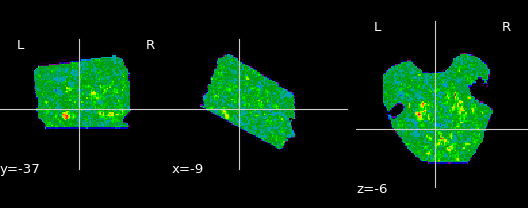

In [31]:
plotting.plot_epi('./sub-01_whole_brain_SL.nii.gz')

**Novel contribution:** be creative and make one new discovery by adding an analysis, visualization, or optimization.

<IPython.core.display.Javascript object>


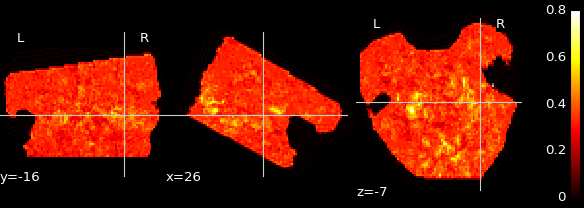

<IPython.core.display.Javascript object>


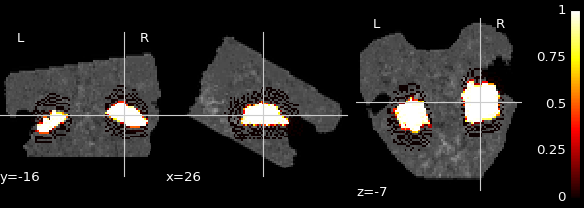

In [43]:
#Plot a pair of images. The top is the searchlight accuracy. The bottom is the FFA localizer.
#The overlap shows that many of the most informative voxels for this task are located in FFA.

plotting.plot_stat_map('./sub-01_whole_brain_SL.nii.gz', 
                      bg_img='/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/masks/sub-01_ventral_FFA_locColl_to_epi1.nii.gz',
                      cut_coords=(26,-16,-7))

plotting.plot_stat_map('/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/masks/sub-01_ventral_FFA_locColl_to_epi1.nii.gz', 
                      bg_img='./sub-01_whole_brain_SL.nii.gz',
                      cut_coords=(26,-16,-7))